# Imports

In [1]:
import pathlib
import warnings

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from tqdm import tqdm
from sklearn import metrics
from sklearn.model_selection import ParameterGrid
from statsmodels.tsa.api import (SimpleExpSmoothing, 
                                 Holt, 
                                 ExponentialSmoothing)

In [4]:
warnings.filterwarnings("ignore")

# Constants

In [5]:
PROJECT_DIR = pathlib.Path('~/work').expanduser()
DATA_DIR = PROJECT_DIR / 'data'

# Data

In [6]:
data = pd.read_csv(
    filepath_or_buffer=DATA_DIR / 'FB.csv', 
    parse_dates=['Date'], 
    index_col=['Date']
)

In [7]:
data.head(10)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-12-08,76.180000,77.250000,75.400002,76.519997,76.519997,25733900
2014-12-09,75.199997,76.930000,74.779999,76.839996,76.839996,25358600
2014-12-10,76.650002,77.550003,76.070000,76.180000,76.180000,32210500
2014-12-11,76.519997,78.519997,76.480003,77.730003,77.730003,33462100
2014-12-12,77.160004,78.879997,77.019997,77.830002,77.830002,28091600
2014-12-15,78.459999,78.580002,76.559998,76.989998,76.989998,29396500
2014-12-16,76.190002,77.389999,74.589996,74.690002,74.690002,31554600
2014-12-17,75.010002,76.410004,74.900002,76.110001,76.110001,29203900
2014-12-18,76.889999,78.400002,76.510002,78.400002,78.400002,34222100


# Split

In [8]:
X = data['Close']

In [9]:
n = 30
X_train = X.iloc[:-n]
X_test = X.iloc[-n:]

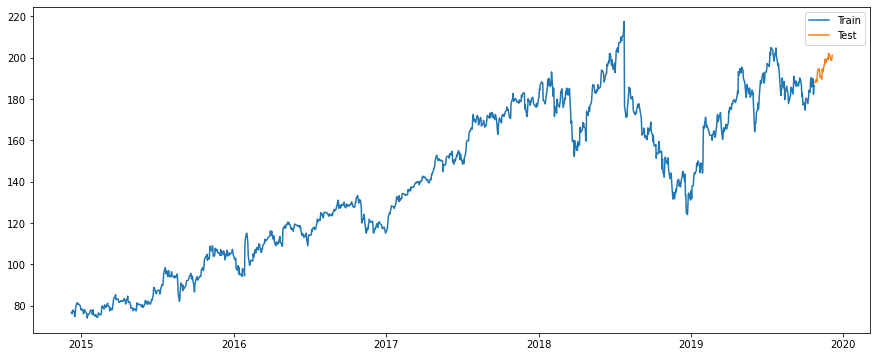

In [10]:
plt.figure(figsize=(15, 6))
plt.plot(X_train, label='Train')
plt.plot(X_test, label='Test')
plt.legend()
plt.show()

# Simple Exponential Smoothing in Action

- smoothing_level (float, optional) – The smoothing_level value of the simple exponential smoothing, if the value is set then this value will be used as the value.
- optimized (bool) – Should the values that have not been set above be optimized automatically?

In [11]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [12]:
def timeseries_evaluation_metrics(y_true, y_pred):
    return {
        'mse': metrics.mean_squared_error(y_true, y_pred),
        'mae': metrics.mean_absolute_error(y_true, y_pred),
        'rmse': metrics.mean_squared_error(y_true, y_pred) ** 0.5,
        'mape': mean_absolute_percentage_error(y_true, y_pred),
        'r2': metrics.r2_score(y_true, y_pred)
    }

In [13]:
ses_param_grid = ParameterGrid({
    'smoothing_level': np.linspace(0, 1, 11)
})

In [14]:
ses_result_df = pd.DataFrame([
    {'parameters': p, 
     **timeseries_evaluation_metrics(
         X_test, 
         (SimpleExpSmoothing(endog=X_train.values)
          .fit(smoothing_level=p['smoothing_level'], 
               optimized=False)
          .forecast(n))
     )}
    for p in tqdm(ses_param_grid)
])

100%|██████████| 11/11 [00:00<00:00, 15.74it/s]


In [15]:
ses_result_df.sort_values('rmse').head()

,parameters,mse,mae,rmse,mape,r2
10,{'smoothing_level': 1.0},97.577979,8.903661,9.878157,4.513334,-4.331317
9,{'smoothing_level': 0.9},98.542985,8.957689,9.926882,4.541013,-4.384041
8,{'smoothing_level': 0.8},100.161555,9.047583,10.008074,4.587068,-4.472474
4,{'smoothing_level': 0.4},101.760166,9.135501,10.087624,4.632110,-4.559817
7,{'smoothing_level': 0.7000000000000001},101.787485,9.136996,10.088978,4.632876,-4.561309


In [16]:
# using values from grid search
model_ses_gs = (SimpleExpSmoothing(endog=X_train.values)
                .fit(smoothing_level=1.0, optimized=False))
X_pred_ses_gs = pd.Series(data=model_ses_gs.forecast(n), 
                          index=X_test.index)
timeseries_evaluation_metrics(X_test, X_pred_ses_gs)

{'mse': 97.57797868071496,
 'mae': 8.90366143333332,
 'rmse': 9.878156643864024,
 'mape': 4.513333762437967,
 'r2': -4.3313166621445145}

In [17]:
model_ses_gs.summary()

Dep. Variable:,endog,No. Observations:,1229
Model:,SimpleExpSmoothing,SSE,8968.966
Optimized:,False,AIC,2446.723
Trend:,None,BIC,2456.951
Seasonal:,None,AICC,2446.756
Seasonal Periods:,None,Date:,"Fri, 27 Nov 2020"
Box-Cox:,False,Time:,12:30:58
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,1.0000000,alpha,False
initial_level,76.519997,l.0,False


In [18]:
# automated search
model_ses_auto = (SimpleExpSmoothing(endog=X_train.values)
                  .fit(optimized=True, use_brute=True))
X_pred_ses_auto = pd.Series(data=model_ses_auto.forecast(n), 
                            index=X_test.index)
timeseries_evaluation_metrics(X_test, X_pred_ses_auto)

{'mse': 97.68044587034159,
 'mae': 8.909413791549577,
 'rmse': 9.883341837169327,
 'mape': 4.516280824860647,
 'r2': -4.336915108051731}

In [19]:
model_ses_auto.summary()

Dep. Variable:,endog,No. Observations:,1229
Model:,SimpleExpSmoothing,SSE,8965.774
Optimized:,True,AIC,2446.285
Trend:,None,BIC,2456.513
Seasonal:,None,AICC,2446.318
Seasonal Periods:,None,Date:,"Fri, 27 Nov 2020"
Box-Cox:,False,Time:,12:30:59
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.9808445,alpha,True
initial_level,76.525895,l.0,True


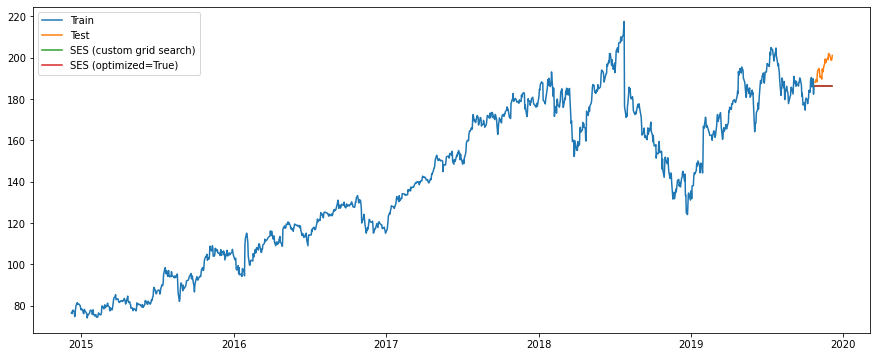

In [20]:
plt.figure(figsize=(15, 6))
plt.plot(X_train, label='Train')
plt.plot(X_test, label='Test')
plt.plot(X_pred_ses_gs, label='SES (custom grid search)')
plt.plot(X_pred_ses_auto, label='SES (optimized=True)')
plt.legend()
plt.show()

# Double Exponential Smoothing in Action

Holt Parameters:
- endog (array-like) – Time series.
- exponential (bool, optional) – Type of trend component.
- damped (bool, optional) – Should the trend component be damped.

fit Parameters:
- smoothing_level (float, optional) – The alpha value of the simple exponential smoothing, if the value is set then this value will be used as the value.
- smoothing_slope (float, optional) – The beta value of the holts trend method, if the value is set then this value will be used as the value.
- damping_slope (float, optional) – The phi value of the damped method, if the value is set then this value will be used as the value.
- optimized (bool, optional) – Should the values that have not been set above be optimized automatically?

In [21]:
des_param_grid = ParameterGrid([
    {'exponential': [False, True], 
     'damped_trend': [False], 
     'smoothing_level': np.linspace(0, 1, 11), 
     'smoothing_trend': np.linspace(0, 1, 11),
     'damping_trend': [None]},
    
    {'exponential': [False, True],
     'damped_trend': [True],
     'smoothing_level': np.linspace(0, 1, 11), 
     'smoothing_trend': np.linspace(0, 1, 11),
     'damping_trend': np.linspace(0, 1, 11)}
])

In [22]:
des_result_df = pd.DataFrame([
    {'parameters': p,
     **timeseries_evaluation_metrics(
         X_test, 
         (Holt(endog=X_train.values, 
               exponential=p['exponential'], 
               damped_trend=p['damped_trend'])
          .fit(smoothing_level=p['smoothing_level'],
               smoothing_trend=p['smoothing_trend'],
               damping_trend=p['damping_trend'],
               optimized=False)
          .forecast(n))
     )}
    for p in tqdm(des_param_grid)
])

100%|██████████| 2904/2904 [09:49<00:00,  4.92it/s]


In [23]:
des_result_df.sort_values('rmse').head()

,parameters,mse,mae,rmse,mape,r2
2779,"{'damped_trend': True, 'damping_trend': 1.0, '...",4.409860,1.747142,2.099967,0.894074,0.759061
117,"{'damped_trend': False, 'damping_trend': None,...",4.409860,1.747142,2.099967,0.894074,0.759061
226,"{'damped_trend': False, 'damping_trend': None,...",4.675432,1.789253,2.162275,0.915498,0.744551
2888,"{'damped_trend': True, 'damping_trend': 1.0, '...",4.675432,1.789253,2.162275,0.915498,0.744551
2780,"{'damped_trend': True, 'damping_trend': 1.0, '...",4.732048,1.768817,2.175327,0.905643,0.741458


In [24]:
# using values from grid search
model_des_gs = (Holt(endog=X_train.values, 
                     exponential=False, 
                     damped_trend=False)
                .fit(smoothing_level=1.0,
                     smoothing_trend=0.7,
                     optimized=False))
X_pred_des_gs = pd.Series(data=model_des_gs.forecast(n), 
                          index=X_test.index)
timeseries_evaluation_metrics(X_test, X_pred_des_gs)

{'mse': 4.409859853530028,
 'mae': 1.7471416871693937,
 'rmse': 2.0999666315277556,
 'mape': 0.8940743710071197,
 'r2': 0.7590608082611028}

In [25]:
model_des_gs.summary()

Dep. Variable:,endog,No. Observations:,1229
Model:,Holt,SSE,14046.508
Optimized:,False,AIC,3002.057
Trend:,Additive,BIC,3022.512
Seasonal:,None,AICC,3002.125
Seasonal Periods:,None,Date:,"Fri, 27 Nov 2020"
Box-Cox:,False,Time:,12:40:54
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,1.0000000,alpha,False
smoothing_trend,0.7000000,beta,False


In [26]:
# automated search
model_des_auto = (Holt(endog=X_train.values, 
                       exponential=False, 
                       damped_trend=False)
                  .fit(optimized=True, 
                       use_brute=True))
X_pred_des_auto = pd.Series(data=model_des_auto.forecast(n), 
                            index=X_test.index)
timeseries_evaluation_metrics(X_test, X_pred_des_auto)

{'mse': 69.50750018199314,
 'mae': 7.521441974926342,
 'rmse': 8.337115819154315,
 'mape': 3.813041684779269,
 'r2': -2.7976447029795932}

In [27]:
model_des_auto.summary()

Dep. Variable:,endog,No. Observations:,1229
Model:,Holt,SSE,8955.547
Optimized:,True,AIC,2448.883
Trend:,Additive,BIC,2469.339
Seasonal:,None,AICC,2448.952
Seasonal Periods:,None,Date:,"Fri, 27 Nov 2020"
Box-Cox:,False,Time:,12:40:54
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.9796487,alpha,True
smoothing_trend,1.4737e-16,beta,True


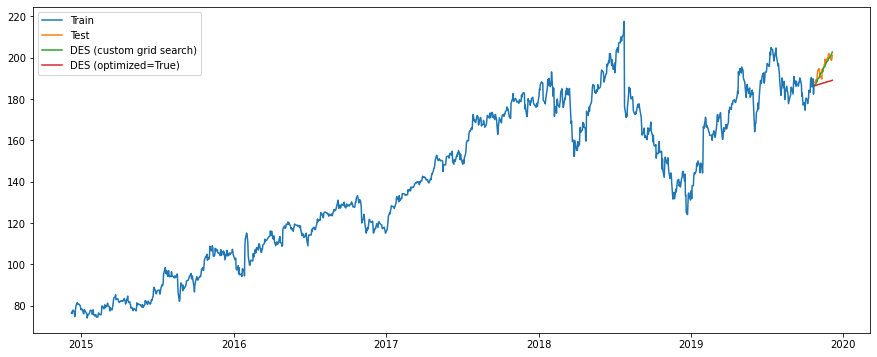

In [28]:
plt.figure(figsize=(15, 6))
plt.plot(X_train, label='Train')
plt.plot(X_test, label='Test')
plt.plot(X_pred_des_gs, label='DES (custom grid search)')
plt.plot(X_pred_des_auto, label='DES (optimized=True)')
plt.legend()
plt.show()

# Triple Exponential Smoothing in Action

ExponentialSmoothing Parameters:
- endog (array-like) – Time series.
- trend ({"add", "mul", "additive", "multiplicative", None}, optional) – Type of trend component.
- damped_trend (bool, optional) – Should the trend component be damped.
- seasonal ({"add", "mul", "additive", "multiplicative", None}, optional) – Type of seasonal component.
- seasonal_periods (int, optional) – The number of seasons to consider for the holt winters.
- use_boxcox ({True, False, 'log', float}, optional) – Should the boxcox tranform be applied to the data first? If ‘log’ then apply the log. If float then use lambda equal to float.

fit Parameters: 
- smoothing_level (float, optional) – The alpha value of the simple exponential smoothing, if the value is set then this value will be used as the value.
- smoothing_slope (float, optional) – The beta value of the holts trend method, if the value is set then this value will be used as the value.
- smoothing_seasonal (float, optional) – The gamma value of the holt winters seasonal method, if the value is set then this value will be used as the value.
- damping_slope (float, optional) – The phi value of the damped method, if the value is set then this value will be used as the value.
- optimized (bool, optional) – Should the values that have not been set above be optimized automatically?
- remove_bias (bool, optional) – Should the bias be removed from the forecast values and fitted values before being returned? Does this by enforcing average residuals equal to zero.
- use_basinhopping (bool, optional) – Should the optimiser try harder using basinhopping to find optimal values?

In [29]:
tes_init_param_grid = ParameterGrid({
    'trend': ['add', 'mul'],
    'damped_trend': [False, True],
    'seasonal': ['add', 'mul'],
    'seasonal_periods': [3, 7, 14, 30, 60, 90, 120, 150, 180],
    'initialization_method': ['estimated'],
    'use_boxcox': [False, True]
})

In [30]:
tes_init_result_df = pd.DataFrame([
    {'parameters': p,
     **timeseries_evaluation_metrics(
         X_test, 
         (
             ExponentialSmoothing(
                 endog=X_train.values,
                 trend=p['trend'], 
                 damped_trend=p['damped_trend'],
                 seasonal=p['seasonal'],
                 seasonal_periods=p['seasonal_periods'],
                 initialization_method=p['initialization_method'],
                 use_boxcox=p['use_boxcox']
             )
             .fit(
                 method='least_squares',
                 optimized=True,
                 use_brute=True
             )
             .forecast(n)
         )
     )}
    for p in tqdm(tes_init_param_grid)
])

100%|██████████| 144/144 [19:01<00:00,  7.93s/it]


In [31]:
tes_init_result_df.sort_values('rmse').head()

,parameters,mse,mae,rmse,mape,r2
69,"{'damped_trend': False, 'initialization_method...",41.061669,6.003372,6.407938,3.055141,-1.243465
68,"{'damped_trend': False, 'initialization_method...",41.286106,6.021276,6.425427,3.064255,-1.255727
71,"{'damped_trend': False, 'initialization_method...",44.057051,6.217715,6.637549,3.163746,-1.407122
70,"{'damped_trend': False, 'initialization_method...",44.143065,6.225292,6.644025,3.167626,-1.411821
32,"{'damped_trend': False, 'initialization_method...",52.933907,6.786380,7.275569,3.449414,-1.892122


In [32]:
tes_fit_param_grid = ParameterGrid({   
    'smoothing_level': np.linspace(0, 1, 11), 
    'smoothing_trend': np.linspace(0, 1, 11),
    'smoothing_seasonal': np.linspace(0, 1, 11)
})

In [33]:
tes_fit_result_df = pd.DataFrame([
    {'parameters': p,
     **timeseries_evaluation_metrics(
         X_test, 
         (
             ExponentialSmoothing(
                 endog=X_train.values,
                 trend='add', 
                 damped_trend=False,
                 seasonal='add',
                 seasonal_periods=180,
                 initialization_method='estimated',
                 use_boxcox=False
             )
             .fit(
                 smoothing_level=p['smoothing_level'],
                 smoothing_trend=p['smoothing_trend'],
                 smoothing_seasonal=p['smoothing_seasonal'],
                 optimized=False
             )
          .forecast(n))
     )}
    for p in tqdm(tes_fit_param_grid)
])

100%|██████████| 1331/1331 [08:22<00:00,  2.65it/s]


In [34]:
tes_fit_result_df.sort_values('rmse').head()

,parameters,mse,mae,rmse,mape,r2
387,"{'smoothing_level': 0.30000000000000004, 'smoo...",3.405591,1.532701,1.845424,0.782390,0.813931
892,"{'smoothing_level': 0.7000000000000001, 'smoot...",4.989425,1.696877,2.233702,0.862570,0.727395
1013,"{'smoothing_level': 0.8, 'smoothing_seasonal':...",5.139141,1.723638,2.266967,0.874625,0.719215
640,"{'smoothing_level': 0.5, 'smoothing_seasonal':...",5.161325,1.662466,2.271855,0.846497,0.718003
650,"{'smoothing_level': 0.5, 'smoothing_seasonal':...",5.263995,1.811036,2.294340,0.922925,0.712394


In [35]:
# using values from grid search
model_tes_gs = (
    ExponentialSmoothing(
        endog=X_train.values,
        trend='add', 
        damped_trend=False,
        seasonal='add',
        seasonal_periods=180,
        initialization_method='estimated',
        use_boxcox=False
    )
    .fit(
        smoothing_level=0.3,
        smoothing_trend=0.2,
        smoothing_seasonal=0.2,
        optimized=False
    )
)
X_pred_tes_gs = pd.Series(data=model_tes_gs.forecast(n), 
                          index=X_test.index)
timeseries_evaluation_metrics(X_test, X_pred_tes_gs)

{'mse': 3.4055912972037796,
 'mae': 1.5327012276434355,
 'rmse': 1.8454244219701277,
 'mape': 0.7823896538801343,
 'r2': 0.8139305007880305}

In [36]:
model_tes_gs.summary()

Dep. Variable:,endog,No. Observations:,1229
Model:,ExponentialSmoothing,SSE,18764.309
Optimized:,False,AIC,3717.954
Trend:,Additive,BIC,4658.922
Seasonal:,Additive,AICC,3784.714
Seasonal Periods:,180,Date:,"Fri, 27 Nov 2020"
Box-Cox:,False,Time:,13:08:21
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.3000000,alpha,False
smoothing_trend,0.2000000,beta,False


In [37]:
# automated search
model_tes_auto = (ExponentialSmoothing(endog=X_train.values)
                  .fit(optimized=True, use_brute=True))
X_pred_tes_auto = pd.Series(data=model_tes_auto.forecast(n), 
                            index=X_test.index)
timeseries_evaluation_metrics(X_test, X_pred_tes_auto)

{'mse': 97.68044587034159,
 'mae': 8.909413791549577,
 'rmse': 9.883341837169327,
 'mape': 4.516280824860647,
 'r2': -4.336915108051731}

In [38]:
model_tes_auto.summary()

Dep. Variable:,endog,No. Observations:,1229
Model:,ExponentialSmoothing,SSE,8965.774
Optimized:,True,AIC,2446.285
Trend:,None,BIC,2456.513
Seasonal:,None,AICC,2446.318
Seasonal Periods:,None,Date:,"Fri, 27 Nov 2020"
Box-Cox:,False,Time:,13:08:23
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.9808445,alpha,True
initial_level,76.525895,l.0,True


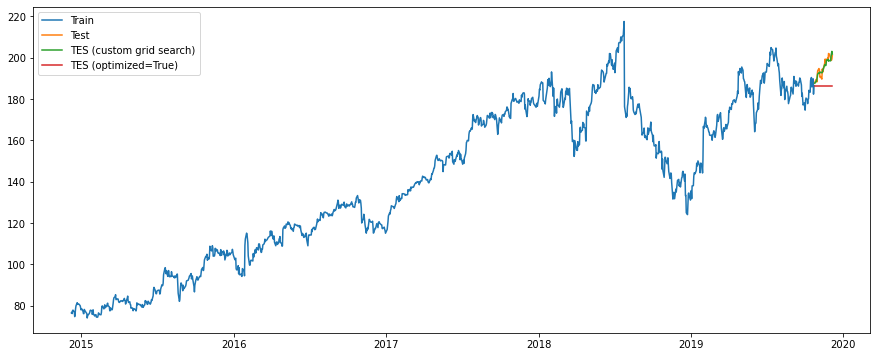

In [39]:
plt.figure(figsize=(15, 6))
plt.plot(X_train, label='Train')
plt.plot(X_test, label='Test')
plt.plot(X_pred_tes_gs, label='TES (custom grid search)')
plt.plot(X_pred_tes_auto, label='TES (optimized=True)')
plt.legend()
plt.show()